In [38]:
!pip -q install lightgbm catboost xgboost

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

print("OK: imports loaded")


OK: imports loaded


In [40]:
data_dir = "."

train = pd.read_csv(f"{data_dir}/train.csv")
test = pd.read_csv(f"{data_dir}/test.csv")
sample_sub = pd.read_csv(f"{data_dir}/sample_submission.csv")

target = "diagnosed_diabetes"
id_col = "id"

print(train.shape, test.shape, sample_sub.shape)
train.head()


(700000, 26) (300000, 25) (300000, 2)


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [41]:
features = [c for c in train.columns if c not in [target, id_col]]
X_df = train[features].copy()
X_test_df = test[features].copy()

cols_to_impute = [
    "bmi", "systolic_bp", "diastolic_bp", "heart_rate",
    "cholesterol_total", "hdl_cholesterol", "ldl_cholesterol", "triglycerides"
]

for col in cols_to_impute:
    if col in X_df.columns:
        median_val = train.loc[train[col] > 0, col].median()
        X_df.loc[X_df[col] <= 0, col] = median_val
        X_test_df.loc[X_test_df[col] <= 0, col] = median_val

print("OK: imputation done")


OK: imputation done


In [42]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # interaction
    if "bmi" in df.columns and "waist_to_hip_ratio" in df.columns:
        df["bmi_waist_ratio"] = df["bmi"] * df["waist_to_hip_ratio"]

    if "age" in df.columns and "physical_activity_minutes_per_week" in df.columns:
        df["age_activity"] = df["age"] * df["physical_activity_minutes_per_week"]

    if "sleep_hours_per_day" in df.columns and "screen_time_hours_per_day" in df.columns:
        df["sleep_screen_ratio"] = df["sleep_hours_per_day"] / (df["screen_time_hours_per_day"] + 0.1)

    # clinical
    if "systolic_bp" in df.columns and "diastolic_bp" in df.columns:
        df["bp_mean"] = (2 * df["diastolic_bp"] + df["systolic_bp"]) / 3

    if "hdl_cholesterol" in df.columns and "cholesterol_total" in df.columns:
        df["cholesterol_ratio"] = df["hdl_cholesterol"] / (df["cholesterol_total"] + 1e-6)

    # discretization
    if "age" in df.columns:
        df["age_group"] = pd.cut(df["age"], bins=[20, 35, 50, 65, 80],
                                 labels=[1, 2, 3, 4], right=False).astype(float)

    if "bmi" in df.columns:
        df["bmi_category"] = pd.cut(df["bmi"], bins=[0, 18.5, 25, 30, 35, 100],
                                    labels=[1, 2, 3, 4, 5], right=False).astype(float)
    return df

X_df = add_features(X_df)
X_test_df = add_features(X_test_df)

print("OK: feature engineering done")


OK: feature engineering done


In [43]:
cat_cols = X_df.select_dtypes(include=["object"]).columns.tolist()

X_all = pd.concat([X_df, X_test_df], axis=0)
X_all_encoded = pd.get_dummies(X_all, columns=cat_cols, drop_first=False)

X_encoded = X_all_encoded.iloc[:len(train)].reset_index(drop=True)
X_test_encoded = X_all_encoded.iloc[len(train):].reset_index(drop=True)

feature_names = X_encoded.columns.to_list()

X = X_encoded.values
X_test = X_test_encoded.values
y = train[target].values

pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / pos

print("Features total:", X_encoded.shape[1])
print(f"Positive: {pos}, Negative: {neg}, scale_pos_weight={scale_pos_weight:.3f}")


Features total: 49
Positive: 436307.0, Negative: 263693.0, scale_pos_weight=0.604


In [44]:
number_of_fold = 5
skf = StratifiedKFold(n_splits=number_of_fold, shuffle=True, random_state=42)
print("OK: CV ready")


OK: CV ready


In [45]:
xgb_fold_aucs = []
xgboost_val_pred = np.zeros(len(train))
xgboost_test_pred = np.zeros(len(test))

xgboost_params = dict(
    n_estimators=2500,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.7,
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    device="cuda",
)

print("\n================ XGBoost ================")
for fold_index, (train_index, valid_index) in enumerate(skf.split(X, y), 1):
    print(f"[XGBoost] {fold_index} / {number_of_fold}")

    X_train_fold, X_valid_fold = X[train_index], X[valid_index]
    y_train_fold, y_valid_fold = y[train_index], y[valid_index]

    model = xgb.XGBClassifier(**xgboost_params)
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)], verbose=False)

    val_pred = model.predict_proba(X_valid_fold)[:, 1]
    xgboost_val_pred[valid_index] = val_pred

    fold_auc = roc_auc_score(y_valid_fold, val_pred)
    xgb_fold_aucs.append(fold_auc)
    print(f"  AUC: {fold_auc:.5f}")

    xgboost_test_pred += model.predict_proba(X_test)[:, 1] / number_of_fold

xgboost_overall_auc = roc_auc_score(y, xgboost_val_pred)
print(f"\n[XGBoost] Overall AUC: {xgboost_overall_auc:.5f}")
print(f"[XGBoost] Mean Fold AUC: {np.mean(xgb_fold_aucs):.5f} (+/- {np.std(xgb_fold_aucs):.5f})")



================ XGBoost ================
[XGBoost] 1 / 5
  AUC: 0.72659
[XGBoost] 2 / 5
  AUC: 0.72537
[XGBoost] 3 / 5
  AUC: 0.72564
[XGBoost] 4 / 5
  AUC: 0.72740
[XGBoost] 5 / 5
  AUC: 0.72645

[XGBoost] Overall AUC: 0.72629
[XGBoost] Mean Fold AUC: 0.72629 (+/- 0.00072)



================ LightGBM ================
[LightGBM] 1 / 5
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Info] Number of positive: 349045, number of negative: 210955
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2838
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 49
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (14.95 MB) transferred to GPU in 0.013547 secs. 1 sparse feature groups
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Cur

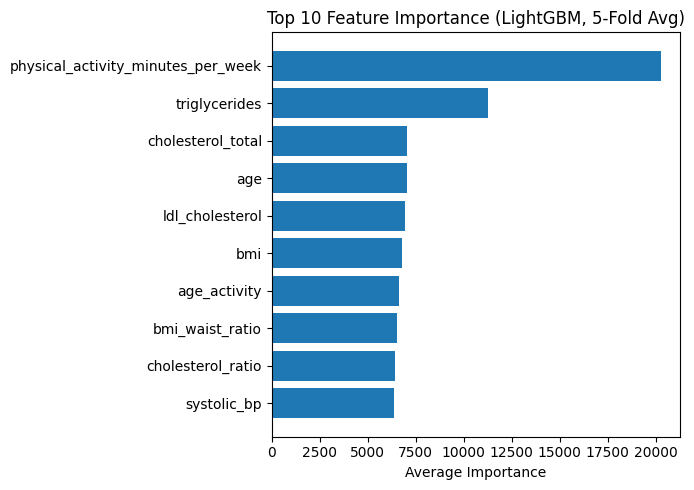

,feature,importance
2,physical_activity_minutes_per_week,20252.8
14,triglycerides,11241.6
11,cholesterol_total,7033.8
0,age,7032.0
13,ldl_cholesterol,6944.6
6,bmi,6773.0
19,age_activity,6620.0
18,bmi_waist_ratio,6511.6
22,cholesterol_ratio,6438.0
8,systolic_bp,6371.4


from matplotlib import pyplot as plt
fi['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
fi['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='importance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

In [46]:
lgb_fold_aucs = []
lightgbm_val_pred = np.zeros(len(train))
lightgbm_test_pred = np.zeros(len(test))

lgb_importance_sum = np.zeros(len(feature_names))

lightgbm_params = dict(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.015,
    n_estimators=8000,
    num_leaves=24,
    max_depth=-1,
    min_data_in_leaf=150,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_lambda=6.0,
    reg_alpha=2.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    device="gpu",
)

print("\n================ LightGBM ================")
for fold_index, (train_index, valid_index) in enumerate(skf.split(X, y), 1):
    print(f"[LightGBM] {fold_index} / {number_of_fold}")

    X_train_fold, X_valid_fold = X[train_index], X[valid_index]
    y_train_fold, y_valid_fold = y[train_index], y[valid_index]

    model = lgb.LGBMClassifier(**lightgbm_params)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_valid_fold, y_valid_fold)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(200, verbose=False)],
    )

    val_pred = model.predict_proba(X_valid_fold, num_iteration=model.best_iteration_)[:, 1]
    lightgbm_val_pred[valid_index] = val_pred

    fold_auc = roc_auc_score(y_valid_fold, val_pred)
    lgb_fold_aucs.append(fold_auc)
    print(f"  AUC: {fold_auc:.5f}")

    lightgbm_test_pred += model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1] / number_of_fold

    lgb_importance_sum += model.feature_importances_

lightgbm_overall_auc = roc_auc_score(y, lightgbm_val_pred)
print(f"\n[LightGBM] Overall AUC: {lightgbm_overall_auc:.5f}")
print(f"[LightGBM] Mean Fold AUC: {np.mean(lgb_fold_aucs):.5f} (+/- {np.std(lgb_fold_aucs):.5f})")


lgb_importance_avg = lgb_importance_sum / number_of_fold
fi = pd.DataFrame({"feature": feature_names, "importance": lgb_importance_avg}) \
       .sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(7,5))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Average Importance")
plt.title(f"Top 10 Feature Importance (LightGBM, {number_of_fold}-Fold Avg)")
plt.tight_layout()
plt.savefig("lgb_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

fi


In [47]:
cat_fold_aucs = []
catboost_val_pred = np.zeros(len(train))
catboost_test_pred = np.zeros(len(test))

cat_params = dict(
    iterations=5000,
    learning_rate=0.02,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False,
    task_type="GPU",
)

print("\n================ CatBoost ================")
for fold_index, (train_index, valid_index) in enumerate(skf.split(X, y), 1):
    print(f"[CatBoost] {fold_index} / {number_of_fold}")

    X_train_fold, X_valid_fold = X[train_index], X[valid_index]
    y_train_fold, y_valid_fold = y[train_index], y[valid_index]

    model = CatBoostClassifier(**cat_params)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_valid_fold, y_valid_fold),
        early_stopping_rounds=100,
        verbose=False,
    )

    val_pred = model.predict_proba(X_valid_fold)[:, 1]
    catboost_val_pred[valid_index] = val_pred

    fold_auc = roc_auc_score(y_valid_fold, val_pred)
    cat_fold_aucs.append(fold_auc)
    print(f"  AUC: {fold_auc:.5f}")

    catboost_test_pred += model.predict_proba(X_test)[:, 1] / number_of_fold

catboost_overall_auc = roc_auc_score(y, catboost_val_pred)
print(f"\n[CatBoost] Overall AUC: {catboost_overall_auc:.5f}")
print(f"[CatBoost] Mean Fold AUC: {np.mean(cat_fold_aucs):.5f} (+/- {np.std(cat_fold_aucs):.5f})")



================ CatBoost ================
[CatBoost] 1 / 5


Default metric period is 5 because AUC is/are not implemented for GPU


  AUC: 0.72519
[CatBoost] 2 / 5


Default metric period is 5 because AUC is/are not implemented for GPU


  AUC: 0.72370
[CatBoost] 3 / 5


Default metric period is 5 because AUC is/are not implemented for GPU


  AUC: 0.72453
[CatBoost] 4 / 5


Default metric period is 5 because AUC is/are not implemented for GPU


  AUC: 0.72569
[CatBoost] 5 / 5


Default metric period is 5 because AUC is/are not implemented for GPU


  AUC: 0.72520

[CatBoost] Overall AUC: 0.72485
[CatBoost] Mean Fold AUC: 0.72486 (+/- 0.00069)


In [48]:
best_auc = -1
best_weights = None

for wx in np.arange(0, 1.01, 0.1):
    for wl in np.arange(0, 1.01 - wx, 0.1):
        wc = 1 - wx - wl
        blended = wx*xgboost_val_pred + wl*lightgbm_val_pred + wc*catboost_val_pred
        score = roc_auc_score(y, blended)
        if score > best_auc:
            best_auc = score
            best_weights = (wx, wl, wc)

wx, wl, wc = best_weights
ensemble_val_pred = wx*xgboost_val_pred + wl*lightgbm_val_pred + wc*catboost_val_pred
ensemble_auc = roc_auc_score(y, ensemble_val_pred)

ensemble_test_pred = wx*xgboost_test_pred + wl*lightgbm_test_pred + wc*catboost_test_pred

print("Best weights (XGB, LGBM, CAT):", best_weights)
print("Best ensemble AUC:", f"{ensemble_auc:.5f}")

results_df = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost", "Ensemble"],
    "CV ROC-AUC (OOF)": [xgboost_overall_auc, lightgbm_overall_auc, catboost_overall_auc, ensemble_auc],
    "Mean Fold AUC": [np.mean(xgb_fold_aucs), np.mean(lgb_fold_aucs), np.mean(cat_fold_aucs), np.nan],
    "Std Fold AUC": [np.std(xgb_fold_aucs), np.std(lgb_fold_aucs), np.std(cat_fold_aucs), np.nan],
})
results_df


Best weights (XGB, LGBM, CAT): (np.float64(0.0), np.float64(1.0), np.float64(0.0))
Best ensemble AUC: 0.72839


,Model,CV ROC-AUC (OOF),Mean Fold AUC,Std Fold AUC
0,XGBoost,0.726289,0.726290,0.000725
1,LightGBM,0.728390,0.728392,0.000713
2,CatBoost,0.724855,0.724861,0.000688
3,Ensemble,0.728390,NaN,NaN


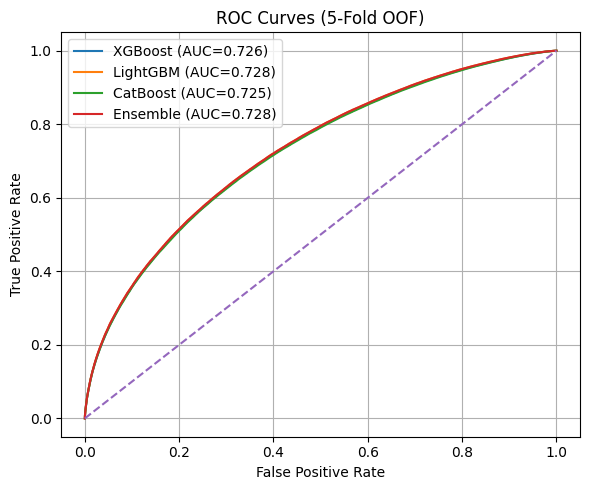

saved: roc_curves.png


In [49]:
plt.figure(figsize=(6,5))
for name, pred in [
    ("XGBoost", xgboost_val_pred),
    ("LightGBM", lightgbm_val_pred),
    ("CatBoost", catboost_val_pred),
    ("Ensemble", ensemble_val_pred),
]:
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_val:.3f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves ({number_of_fold}-Fold OOF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

print("saved: roc_curves.png")


In [ ]:
submission = sample_sub.copy()
submission[target] = ensemble_test_pred
submission.to_csv("submission_final.csv", index=False)

print("saved: submission_final.csv")
print("saved: lgb_feature_importance.png")
